In [6]:
# import non-SOMPY modules
import pickle
import numpy as np
import numpy.linalg as linalg
import scipy.io as sio

from sklearn import preprocessing, svm
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, precision_score, jaccard_similarity_score
from sklearn.cross_validation import train_test_split
from scipy import stats
from tempfile import TemporaryFile

In [7]:
from sompy import sompy as sp

%matplotlib inline
import matplotlib.pyplot as plot
import matplotlib.patches as patch

from sompy.visualization.mapview import View2D
from sompy.visualization.hitmap import HitMapView
from sompy.visualization.umatrix import UMatrixView
from sompy.visualization.dotmap import DotMapView

In [13]:
"""
SOM manipulating functions
"""


#### initialize and train a SOM of provided size, learning rate, etc and train on dataset
## also, create output dump about training process, general network statistics, etc.
## h = som height, default 32
## w = som width, default 32
def somWrap(data,h=32,w=32,init='pca',job=1,shared='no',verb='info'):
    #create output file

    #create SOM
    my_som = sp.SOMFactory.build(data,mapsize=[h,w],initialization=init)
    #train som
    my_som.train(n_job=job,shared_memory=shared,verbose=verb) #default args: n_job=1,shared_memory='no',verbose='info'
    #fill output file, close output file

    #return trained SOM
    return my_som

####saves the SOM for later
def somSave(SOM,name):
    #try:
        #pickle SOM with name 'name'
        #print 'SOM '+str(name)+'successfully stored'
    #catch:
        #print 'there was a problems storing '+str(name)+'SOM, for some reason'
    return 0#PLACEHOLDER

####loads up a saved SOM for further analysis
def somLoad(name):
    #unpickle SOM with name 'name'
    #return SOM
    return 0#PLACEHOLDER

#### generates a 'tome' array holding the eculidean distance of each SOM node
## for each item in dataset presented to trained map, like a 'heatmap' of each
## item of data.
## intendted uses:
##  -prediction with SVM/other classifier
##  -comparing eluclidian distance between epoch mapings
##  -generating heatmaps of single epochs
##  -training a further map for 2nd level feature extraction
def tomeGen(SOM, dataset,flat=True,dat_no=900,dat_len=2500):
    #create simple list to hold activation heatmaps
    tomeLis = []
    #extract som's codebook
    cbook = SOM.codebook
    #for all presented data, note it does NOT need to be data map was trained on
    for data in dataset:
        entry = sliceHeat(cbook,data,graph = False)
        tomeLis.append(entry)        
    #convert the list to a numpy array, not done earlier because it converts
    # the list to an ideal (n,h,w) 3D format, where n is number of data samples,
    # h is map height, and w is map width
    tome = np.array(tomeLis)
    if flat==True:
        tome = tome.reshape((dat_no,dat_len))
    #return finished tome
    return tome

def bmuTomeGen(SOM,dataset,bmu_no=100):
    bmuLis = []

    for data in dataset:
        bmus = SOM.find_k_nodes(data,k=bmu_no)[1][0]
        xy = SOM.bmu_ind_to_xy(bmus)[:,:2]
        flatxy = np.reshape(xy,(200))
        scaler = 50.0
        scalexy = [i / scaler for i in flatxy]
        bmuLis.append(scalexy)

    return bmuLis



"""
visualization funcitons
"""
#### create labeled graphs with exemplar/colour patches to identify clustering
## hitmap, umatrix, and dotmap
def descView(SOM,name = 'K-means Map Node Vector Clustering'):
    #build viewers
    hitV = HitMapView(10,10,(str(name)+' hitmap'),text_size=15)
    umatV = UMatrixView(25,25,(str(name)+' U-matrix'),text_size=15,blob=True,labels=True)
    #dotV = DotMapView(10,15,'dotmap')
    #show viewers
    hitV.show(SOM)
    umatV.show(SOM)
    #dotV.show(SOM)


#### present trained map with a subsection of timeslices, generate graph of bmu's
## for each slice. if the default supslice=1 is left, uses all slices
def sliceOverView(SOM,data,subslice,labels):
    #create empty graph sliceGraph   
    #seperate out a total/subslice size fraction of data to graph as array
    #seperate out the column that denotes data labels from subslice as list
    #for each slice in subslices:
        #generate label for slice        
        #generate bmu's for slice
        #generate [x,y] for bmu
        #plot entry on sliceGraph at [x,y] with [label]
    #add axis labels, window dressings, etc.
    #return plot
    return 0#PLACEHOLDER

#### present trained map with single timeslice, return what cluster it belongs to
def bmuSliceView(SOM,data,name,volume=25):
    #create empty sliceGraph named [name]
    #find K bmus within SOM for given single data item, where K=volume
    #for each bmu with iterator i:
        #generate [x,y] for bmu
        #graph bmu at [x,y] with label [i+1] (higher label num -> worse match) 
    return 0#PLACEHOLDER



def sliceHeat(cbook,data,sliceLabel='',graph = True):
    #import for scaling
    minmax = preprocessing.MinMaxScaler()
    #create heat array for plotting
    heat = np.array([])
    #extract SOM's codebook, best done here so evertthing can be accessed properly
    #cbook = SOM.codebook
    #for node in code book:
    for node in cbook.matrix:
        #get summed activity for data
        nAct = linalg.norm(np.abs(data-node))
        #append node activity to heat
        heat = np.append(heat,nAct)
    #reshape heat to the same dimensions as orign map
    mz0 = cbook.mapsize[0]
    mz1 = cbook.mapsize[1]
    heat = np.reshape(heat,(mz0,mz1))    
    #scale heatmap to within 0-1 range
    scheat = minmax.fit_transform(heat)

    #if a heatmap style graph is desired (on by default)
    if graph == True:
        #show plot    
        quickHeat(scheat,ttl=sliceLabel)

    return scheat 

#### a lazy function to plot heatmaps, assuming it's all in the right format
def quickHeat(toHeat,cmap='Spectral', interpolation='nearest',ttl=''):
    heatPl = plot.imshow(toHeat, cmap=cmap, interpolation=interpolation)
    plot.colorbar(heatPl)
    plot.title(ttl)
    return heatPl

#### another lazy function for generating heatmap contrasts of
## two data activity mappings/heatmaps; also returns
## contrast as array
def quickHComp(dat1,dat2,SOM,label=''):
    heat1 = sliceHeat(SOM.codebook,dat1,graph=False)
    heat2 = sliceHeat(SOM.codebook,dat2,graph=False)
    absheat = (abs(heat1-heat2))*2
    quickHeat(absheat,ttl=label)
    return absheat


#### generate a group of k bmu's for two slices, and compare the average
##  distance between the two groups; return this average
## If desired, also generate a scatterplot that shows the two
##  groups as they are located in on map
def clustComp(data1,data2,SOM,e1='Epoch 1',e2='Epoch 2',bmu_no=100, bmuplot = True,titl='BMU comparison'):

    #generate k bmu's for data 1 (d1), assign to vector (v1)
    v1 = SOM.find_k_nodes(data1,k=bmu_no)[1][0]
    #generate k bmu's for data 2 (d2), assign to vector (v2)
    v2 = SOM.find_k_nodes(data2,k=bmu_no)[1][0]

    #get (x,y) for v1 bmu's, assing to vector (xy1) 
    xy1 = SOM.bmu_ind_to_xy(v1)[:,:2]
    #get (x,y) for v2 bmu's, assing to vector (xy2)
    xy2 = SOM.bmu_ind_to_xy(v2)[:,:2]

    #make a 'weighting' array to ensure better bmu's have more influence over score
    weighting = np.linspace(.75,0.01,num=bmu_no)
    weighting[0] = 1.0

    #if a plot is desired
    if bmuplot == True:
        #set up rgb arrays for both bmu sets
        gr = np.zeros((bmu_no,4))
        blu = np.zeros((bmu_no,4))
        # make a green and blue array
        gr[:,1] = 1.0
        blu[:,2] = 1.0
        # apply weighting to point alpha value
        gr[:, 3] = weighting        
        blu[:, 3] = weighting

        #create bmu comparison pyplot
        plot.scatter(xy1[:,0],xy1[:,1],c=gr)
        plot.scatter(xy2[:,0],xy2[:,1],c=blu)
        #set axis range to map size
        plot.xlim(0,50)
        plot.ylim(0,50)
        #build/show legend
        grhand = patch.Patch(color='green', label=e1)
        blhand = patch.Patch(color='blue', label=e2)
        #plot.legend(handles=[grhand,blhand])
        plot.legend([grhand,blhand],[e1,e2],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #add labels
        plot.title(e1+' vs '+e2+' '+titl)
        #show cplot 
        plot.show()

    #calculate average euclidian distance between x,y [0:1] of v1 and v2
    bmuDist = np.average(np.abs(xy1-xy2),axis=0,weights=weighting)    
    #return average distance    
    return bmuDist

# #### adapted from scikitlearn documentaiton, generates a confusion matrix, classification
# ## report, and hamming distance
# def svmDesc(lab_pred,lab_test, title='Confusion matrix', cmap=plot.cm.Blues,taskLabels=taskLabels,normal=True):
#     #build confussion matrix itself
#     conM = confusion_matrix(lab_test, lab_pred)
#     if normal== True:
#         conM = conM.astype('float') / conM.sum(axis=1)[:, np.newaxis]
#     #build heatmap graph of matrix
#     plot.imshow(conM, interpolation='nearest', cmap=cmap)
#     plot.title(title)
#     plot.colorbar()
#     tick_marks = np.arange(len(taskLabels))
#     plot.xticks(tick_marks, taskLabels, rotation=45)
#     plot.yticks(tick_marks, taskLabels)
#     plot.tight_layout()
#     plot.ylabel('True label')
#     plot.xlabel('Predicted label')

#     #classification report
#     creport = classification_report(lab_test,lab_pred)
#     print "CLASSIFICATION REPORT: "  
#     print creport

#     #hamming distance
#     hamming = hamming_loss(lab_test,lab_pred)
#     print "HAMMING DISTANCE:              %s" % str(hamming)

#     #jaccard similarity score
#     jaccard = jaccard_similarity_score(lab_test,lab_pred)
#     print "JACCARD SIMILARITY SCORE:      %s" % str(jaccard)

#     #precision score    
#     pscore = precision_score(lab_test,lab_pred)
#     print "PRECISION SCORE:               %s" % str(pscore)


In [14]:
"""
SVM functions
"""           

def svmWrap(data,predict,svmtype=2,split=.4,ker='rbf',gam=0.01,workup=True,dec_shape='ovr',title='',stat=False,statLis=None):
    #create svm
    if svmtype==1: #standard svm, ~74% performance
        clsf = svm.SVC(decision_function_shape=dec_shape,kernel=ker,gamma=gam)
    elif svmtype==2: #nusvm, ~78% performance
        clsf = svm.NuSVC(decision_function_shape=dec_shape,kernel=ker,gamma=gam)
    elif svmtype==3: #linear svm 60% performance
        clsf = svm.LinearSVC()
    elif svmtype==4: # % performance
        clsf = svm.SVR(decision_function_shape=dec_shape,kernel=ker,gamma=gam)
    elif svmtype==5: # % performance
        clsf = svm.NuSVR(decision_function_shape=dec_shape,kernel=ker,gamma=gam)
    elif svmtype==6: # % performance
        clsf = svm.LinearSVR()
    #seperate out some test/train data and labels    
    dat_train, dat_test, lab_train, lab_test = train_test_split(data,predict, test_size=split)
    #train the svm, giving an analyitical workup if desired
    if workup==True:
        lab_pred = clsf.fit(dat_train, lab_train).predict(dat_test)
        svmDesc(lab_pred,lab_test,title=title)
    else:
        clsf.fit(dat_train,lab_train)
        #see how good svm's performance is in brief if long workup isn't required
        pscore = clsf.score(dat_test,lab_test)
        if stat == False:           
            print 'PREDICTIVE PERFORMANCE:        %s' % str(pscore)
        else:
            statLis.append(pscore)
    #return trained classifier
    return clsf


#three SVM's wrapped together to deliver a better predictive performance
def tribunalWrap(data, predict, svm_no=3,split=.4,ker='rbf',gam=2,workup=True,dec_shape='ovr',full_workup=False):
    print 'Convening SVM tribunal....'
    svcClsf1 = svm.SVC(kernel=ker,gamma=gam,decision_function_shape=dec_shape)
    print 'First member instantied'    
    nusvcClsf = svm.NuSVC(kernel=ker,gamma=gam,decision_function_shape=dec_shape)
    print 'Second member instantied'
    svcClsf2 = svm.SVC(kernel=ker,gamma=gam,decision_function_shape=dec_shape)    
#    linClsf = svm.LinearSVC()
    print 'Third member instantied'    

    tribunal = [svcClsf1,nusvcClsf,svcClsf2]#linClsf]

    if workup==True:
        tribunalTrain(data,predict,tribunal,split=split)

    return tribunal

def parlimentWrap(data, predict, svm_type=2, svm_no=3,split=.4,ker='rbf',gam=2,workup=True,dec_shape='ovr',full_workup=False,stat=False,statLis=None):
    tribunal = []
    print 'Convening SVM parliment....'
    for i in range(svm_no):
        if svm_type==1:
            tribunal.append(svm.SVC(kernel=ker,gamma=gam,decision_function_shape=dec_shape))
        elif svm_type==2:
            tribunal.append(svm.NuSVC(kernel=ker,gamma=gam,decision_function_shape=dec_shape))
        elif svm_type==3:
            tribunal.append(svm.LinearSVC())
        print 'judge %s instantiated'%str(i+1)
    if stat==True:
        tribunalTrain(data,predict,tribunal,split=split,stat=stat,statLis=statLis)
    if workup==True:
        tribunalTrain(data,predict,tribunal,split=split)


    return tribunal        


def parlimentStat(data, predict, svm_type=1, svm_no=3,split=.4,ker='rbf',gam=0.01,workup=True,dec_shape='ovo',full_workup=False):
    tribunal = []
    print 'Convening SVM parliment....'
    for i in range(svm_no):
        if svm_type==1:
            tribunal.append(svm.SVC(kernel=ker,gamma=gam,decision_function_shape=dec_shape))
        elif svm_type==2:
            tribunal.append(svm.NuSVC(kernel=ker,gamma=gam,decision_function_shape=dec_shape))
        elif svm_type==3:
            tribunal.append(svm.LinearSVC())
        print 'judge %s instantiated'%str(i+1)

    if workup==True:
        tribunalTrain(data,predict,tribunal,split=split)

    return tribunal         

def hybridKernelWrap(data, predict, svm_no=3,split=.4,gam=2,workup=True,dec_shape='ovo',full_workup=False):
    tribunal = []
    print 'Convening SVM parliment....'
    for i in range(int(svm_no/3)):
        tribunal.append(svm.SVC(kernel='linear',gamma=gam,decision_function_shape=dec_shape))
        print 'linear judge No.%s instantiated'%str(i+1)
    for i in range(int(svm_no/3)):
        tribunal.append(svm.SVC(kernel='rbf',gamma=gam,decision_function_shape=dec_shape))
        print 'rbf judge No.%s instantiated'%str(i+1)
    for i in range(int(svm_no/3)):
        tribunal.append(svm.SVC(kernel='poly',gamma=gam,decision_function_shape=dec_shape))
        print 'poly judge No.%s instantiated'%str(i+1)

    if workup==True:
        tribunalTrain(data,predict,tribunal,split=split)

    return tribunal
def tribunalTrain(data,predict,tribunal,split=.2,stat=False,statLis=None):
    #data for testing the tribunal performance, not in actual judge training
    dat_train, dat_test, lab_train, lab_test = train_test_split(data,predict, test_size=split)
    verdict = []

    print 'Tribunal in session'

    for judge in tribunal:
        jdat_train, jdat_test, jlab_train, jlab_test = train_test_split(dat_train,lab_train, test_size=split)
        judge.fit(jdat_train, jlab_train)
        print 'judge trained'

    for d in dat_test:
        votes = []
        for judge in tribunal:
            v = judge.predict(d)
            votes.append(v)
        decision = stats.mode(votes,axis=None)
        verdict.append(decision[0])
    npVerdict = np.array(verdict)

    if stat == False:        
        svmDesc(npVerdict,lab_test,title='Tribunal Confusion Matrix')
    else:
        jac = jaccard_similarity_score(npVerdict,lab_test)
        statLis.append(jac)

def tribunalTest(tribunal,data):
    verdict = []
    for d in data:
        votes = []
        for judge in tribunal:
            v = judge.predict(d)
            votes.append(v)
        decision = stats.mode(votes,axis=None)
        verdict.append(decision[0])
    npVerdict = np.array(verdict)
    return npVerdict

In [9]:
subj_001_atlasTS = np.load('p1_TS_HarvardOxford-cortl-maxprob-thr25-2mm.npy')
print subj_001_atlasTS.shape

(180L, 96L)


In [18]:
#test the SOM clustering modules
som_001 = somWrap(subj_001_atlasTS, h = 16, w = 16, init = 'pca')

 Training...
 pca_linear_initialization took: 0.006000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 43

 epoch: 1 ---> elapsed time:  0.008000, quantization error: 8.077469

 epoch: 2 ---> elapsed time:  0.012000, quantization error: 7.603258

 epoch: 3 ---> elapsed time:  0.004000, quantization error: 7.077718

 epoch: 4 ---> elapsed time:  0.008000, quantization error: 6.888662

 epoch: 5 ---> elapsed time:  0.008000, quantization error: 6.775885

 epoch: 6 ---> elapsed time:  0.008000, quantization error: 6.687746

 epoch: 7 ---> elapsed time:  0.008000, quantization error: 6.604046

 epoch: 8 ---> elapsed time:  0.004000, quantization error: 6.550824

 epoch: 9 ---> elapsed time:  0.007000, quantization error: 6.501785

 epoch: 10 ---> elapsed time:  0.007000, quantization error: 6.460773

 epoch: 11 ---> elapsed time:  0.008000, quantization error: 6.426880

 epoch: 12 ---> elapsed time:  0.008000, quantization error: 6.393672

 epoch: 13 --

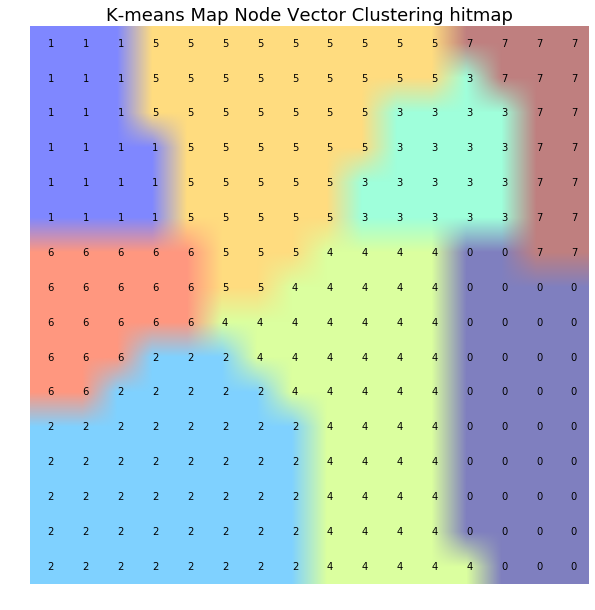

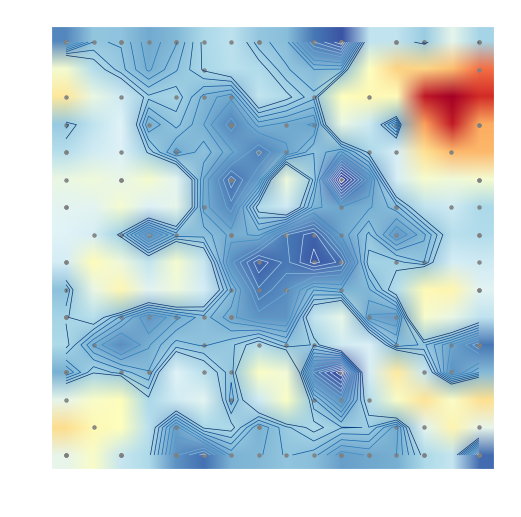

In [19]:
descView(som_001)

In [33]:
def tomeGen(SOM, dataset,flat=True,dat_no=900,dat_len=2500):
    #create simple list to hold activation heatmaps
    tomeLis = []
    #extract som's codebook
    cbook = SOM.codebook
    #for all presented data, note it does NOT need to be data map was trained on
    for data in dataset:
        entry = sliceHeat(cbook,data,graph=False)
        tomeLis.append(entry)        
    #convert the list to a numpy array, not done earlier because it converts
    # the list to an ideal (n,h,w) 3D format, where n is number of data samples,
    # h is map height, and w is map width
    tome = np.array(tomeLis)
    dat_no = tome.shape[0]
    dat_len = tome.shape[1] * tome.shape[2]
    if flat==True:
        tome = tome.reshape((dat_no,dat_len))
    #return finished tome
    return tome

In [34]:
tomr_001 = tomeGen(som_001,subj_001_atlasTS)

In [57]:
bmuLis = []
bmu_no = 100
# for data in subj_001_atlasTS:
data = subj_001_atlasTS[0,:]
bmus = som_001.find_k_nodes(data,k=bmu_no)[1][0]
xy = som_001.bmu_ind_to_xy(bmus)[:,:2]
flatxy = np.reshape(xy,(200))
scaler = float(16)
scalexy = [i / scaler for i in flatxy]
bmuLis.append(scalexy)

C:\Users\Hao-Ting\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [58]:
bmuLis

[[0.1875,
  0.9375,
  0.125,
  0.9375,
  0.1875,
  0.875,
  0.125,
  0.875,
  0.25,
  0.9375,
  0.25,
  0.875,
  0.3125,
  0.9375,
  0.3125,
  0.875,
  0.125,
  0.8125,
  0.0625,
  0.875,
  0.0625,
  0.8125,
  0.25,
  0.8125,
  0.0,
  0.8125,
  0.1875,
  0.8125,
  0.0625,
  0.9375,
  0.3125,
  0.8125,
  0.0,
  0.75,
  0.375,
  0.875,
  0.625,
  0.6875,
  0.375,
  0.9375,
  0.0625,
  0.75,
  0.625,
  0.625,
  0.5625,
  0.6875,
  0.0,
  0.875,
  0.625,
  0.75,
  0.5625,
  0.75,
  0.5625,
  0.625,
  0.6875,
  0.6875,
  0.375,
  0.8125,
  0.6875,
  0.75,
  0.625,
  0.5625,
  0.3125,
  0.75,
  0.5625,
  0.5625,
  0.625,
  0.8125,
  0.25,
  0.75,
  0.4375,
  0.875,
  0.5625,
  0.8125,
  0.5,
  0.6875,
  0.5625,
  0.5,
  0.0625,
  0.3125,
  0.4375,
  0.9375,
  0.0,
  0.3125,
  0.5625,
  0.4375,
  0.25,
  0.6875,
  0.625,
  0.5,
  0.5625,
  0.3125,
  0.5,
  0.75,
  0.0625,
  0.6875,
  0.5,
  0.4375,
  0.5,
  0.3125,
  0.625,
  0.375,
  0.375,
  0.25,
  0.5625,
  0.375,
  0.0625,
  0.375,
  0.0